# От Идеи к Prod`у

## 0. Введение и Подготовка


*   **Цели занятия:** Понять и пройти основные этапы создания и развертывания простого DS-решения.
*   **Бизнес-кейс:** Предсказание стоимости поездки на такси.
*   **Инструменты:** Обзор используемых технологий (Python, SQLite, Pandas, Scikit-learn, FastAPI, Streamlit, Docker, Git, WSL2).
*   **План работы:** Обзор шагов от данных до работающего API на сервере.

### 0.1 Настройка Рабочего Окружения

In [ ]:
Создадим папку для проекта и настроим виртуальное окружение:


```bash
# Создаем папку проекта
mkdir taxi_predictor_project
cd taxi_predictor_project

In [ ]:
# Инициализируем Git репозиторий
git init

In [ ]:
# Создаем виртуальное окружение
python3 -m venv .venv

In [ ]:
# Активируем окружение
source .venv/bin/activate 
# Для Windows CMD/PowerShell: .venv\Scripts\activate

In [ ]:
# Создаем файл зависимостей (пока пустой или с первыми пакетами)
touch requirements.txt
echo "jupyterlab" >> requirements.txt 
echo "pandas" >> requirements.txt
echo "scikit-learn" >> requirements.txt
echo "joblib" >> requirements.txt # Или pickle, если предпочитаешь
# Добавим остальные позже по мере необходимости
cat requirements.txt

In [ ]:
# Устанавливаем зависимости
pip install -r requirements.txt

In [ ]:
# Добавим .gitignore
echo ".venv/" >> .gitignore
echo "__pycache__/" >> .gitignore
echo "*.db" >> .gitignore # Обычно БД не хранят в гите, но для демо можно закомментить
echo "*.joblib" >> .gitignore # Модель тоже часто хранят отдельно (LFS или облако), но для демо можно закомментить
echo "*.pkl" >> .gitignore
echo ".ipynb_checkpoints/" >> .gitignore
echo ".DS_Store" >> .gitignore

In [ ]:
# Первый коммит
git add .
git commit -m "Initial project setup with venv and gitignore"

# Запускаем Jupyter Lab (или Notebook)
jupyter lab 

## 1. Подготовка Данных: Создание и Наполнение БД


Задача: Превратить "сырые" данные (CSV) в структурированную базу данных SQLite.

**Действия:**


- Прочитать исходный CSV-файл (raw_taxi_data.csv) с помощью Pandas.
- Создать соединение с SQLite базой данных (taxi_data.db).
- Записать данные из DataFrame в таблицу rides в SQLite.
- Проверить, что данные успешно записались (например, прочитать несколько строк из БД).

In [ ]:
import pandas as pd
import sqlite3

# Убедимся, что у нас есть сырой CSV файл (например, создадим его)
# Или скачаем/скопируем в папку проекта
# Допустим, он называется 'raw_taxi_data.csv'

try:
    df_raw = pd.read_csv('~/work/taxi_predictor_project/raw_taxi_data.csv')
    print("CSV файл успешно прочитан.")

    # Создаем/подключаемся к БД
    db_name = 'taxi_data.db'
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    print(f"Подключились к БД {db_name}")

    # Записываем DataFrame в таблицу 'rides'
    # if_exists='replace' перезапишет таблицу, если она уже есть. 
    # Используйте 'append', если нужно добавить данные.
    df_raw.to_sql('rides', conn, if_exists='replace', index=False)
    print("Данные записаны в таблицу 'rides'.")

    # Проверка: прочитаем первые 5 строк из БД
    df_from_db = pd.read_sql('SELECT * FROM rides LIMIT 5', conn)
    print("\nПервые 5 строк из БД:")
    print(df_from_db)

    # Закрываем соединение
    conn.close()
    print("\nСоединение с БД закрыто.")

except FileNotFoundError:
    print("Ошибка: Файл 'raw_taxi_data.csv' не найден. Убедитесь, что он в папке проекта.")
except Exception as e:
    print(f"Произошла ошибка: {e}")

# 2. Анализ и Моделирование

*   **Задача:** Провести быстрый анализ данных из БД, подготовить их и обучить модель регрессии для предсказания `price`.
*   **Действия:**
    *   Подключиться к `taxi_data.db`.
    *   Загрузить данные из таблицы `rides` в Pandas DataFrame.
    *   Провести EDA: описательные статистики, визуализации (опционально).
    *   Предобработка данных:
        *   Обработка категориальных признаков (`time_of_day`) - One-Hot Encoding.
        *   Выделение признаков (X) и целевой переменной (y).
    *   Разделение данных на обучающую и тестовую выборки.
    *   Выбор и обучение простой модели (Линейная Регрессия).
    *   Оценка модели на тестовой выборке (MAE).
    *   **Важно:** Сохранение обученной модели и препроцессора в файлы `.joblib`.

## 2.1 Загрузка и Первичный Анализ Данных

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import sqlite3
import joblib # Для сохранения/загрузки объектов Python (модели, препроцессоры)

# Устанавливаем опцию для отображения всех столбцов DataFrame
pd.set_option('display.max_columns', None) 

In [ ]:
# --- Загрузка данных из SQLite ---
db_name = 'taxi_data.db' # Убедитесь, что файл БД в той же папке или укажите путь

try:
    conn = sqlite3.connect(db_name)
    # Загружаем всю таблицу 'rides' в DataFrame
    df = pd.read_sql('SELECT * FROM rides', conn)
    conn.close()
    print(f"Данные успешно загружены из таблицы 'rides' базы данных '{db_name}'.")
    print(f"Загружено строк: {len(df)}")
except Exception as e:
    print(f"Ошибка при подключении или чтении из БД '{db_name}': {e}")
    # В реальном проекте здесь может быть более сложная обработка ошибки
    # Для лекции можно остановить выполнение, если данные не загрузились
    raise SystemExit("Не удалось загрузить данные, дальнейшее выполнение невозможно.")


In [ ]:
# --- Быстрый осмотр данных (EDA) ---

print("\nПервые 5 строк данных:")
display(df.head()) # Используем display в Jupyter для красивого вывода

print("\nИнформация о типах данных и пропусках:")
df.info()

print("\nОписательные статистики для числовых признаков:")
display(df.describe().round(2))

print("\nОписательные статистики для категориальных признаков:")
display(df.describe(include=['object']))

print("\nПроверка на наличие явных пропусков:")
print(df.isnull().sum())

In [ ]:
## 2.2 Предобработка Данных

Нам нужно преобразовать категориальный признак `time_of_day` в числовой формат, который поймет модель. Будем использовать One-Hot Encoding.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer # Для применения разных трансформаций к разным столбцам

# --- Определение признаков (X) и целевой переменной (y) ---
target = 'price'
# Выбираем признаки, которые будем использовать для моделирования
# Исключаем целевую переменную 'price'
features = df.columns.drop(target) 

X = df[features]
y = df[target]

print("Признаки (X):")
display(X.head(3))
print("\nЦелевая переменная (y):")
display(y.head(3))

# --- Определение типов признаков для препроцессинга ---
categorical_features = ['time_of_day'] 
# Все остальные признаки в нашем случае - числовые или бинарные (weekend), 
# которые можно рассматривать как числовые для линейной модели.
# Если бы были другие числовые признаки, требующие масштабирования,
# их бы выделили отдельно (например, StandardScaler).
numerical_features = ['distance_km', 'weekend', 'passengers'] 

print(f"\nКатегориальные признаки: {categorical_features}")
print(f"Числовые признаки: {numerical_features}")

In [ ]:
# --- Создание препроцессора ---
# ColumnTransformer позволяет применить разные шаги обработки к разным столбцам

# Создаем экземпляр OneHotEncoder. 
# handle_unknown='ignore' важен: если в новых данных (при предсказании) 
# встретится категория, которой не было в обучении, он не выдаст ошибку, 
# а просто создаст для нее столбец из нулей.
# sparse=False (устарело, используйте sparse_output=False в новых версиях): 
# чтобы результат был плотным numpy массивом, а не разреженной матрицей (удобнее для просмотра)
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 

# Создаем ColumnTransformer:
# 1. 'cat': имя шага
# 2. OneHotEncoder(): трансформер, который применяем
# 3. categorical_features: список столбцов, к которым его применяем
# remainder='passthrough': означает, что все остальные столбцы (не указанные в transformers) 
# должны остаться без изменений и добавиться к результату. В нашем случае это numerical_features.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe_encoder, categorical_features)
    ],
    remainder='passthrough' 
)

print("\nПрепроцессор готов.")
# Мы его пока не применяем, он будет обучен ('fit') на обучающей выборке.

## 2.3 Разделение Данных на Обучающую и Тестовую Выборки

Разделим наши данные, чтобы обучить модель на одной части (train), а проверить ее качество на другой, которую модель еще не видела (test).

In [ ]:
# Разделяем X и y на обучающую (80%) и тестовую (20%) выборки
# random_state обеспечивает воспроизводимость разделения: при каждом запуске 
# с тем же random_state разделение будет одинаковым.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки X_train: {X_train.shape}")
print(f"Размер тестовой выборки X_test: {X_test.shape}")
print(f"Размер обучающей выборки y_train: {y_train.shape}")
print(f"Размер тестовой выборки y_test: {y_test.shape}")

## 2.4 Обучение Модели

Теперь обучим препроцессор на обучающих данных и применим его для преобразования и обучающей, и тестовой выборок. Затем на преобразованных обучающих данных обучим модель линейной регрессии.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Обучение препроцессора и трансформация данных ---

# Обучаем препроцессор ТОЛЬКО на обучающих данных (X_train)
# Метод fit_transform одновременно обучает (fit) и преобразует (transform) данные
print("Обучаем препроцессор и трансформируем X_train...")
X_train_processed = preprocessor.fit_transform(X_train)
print("X_train успешно преобразован.")

# Применяем уже ОБУЧЕННЫЙ препроцессор к тестовым данным (X_test)
# Используем только метод transform, НЕ fit_transform!
print("\nТрансформируем X_test...")
X_test_processed = preprocessor.transform(X_test)
print("X_test успешно преобразован.")

# Посмотрим на результат трансформации
# Имена столбцов после OHE могут быть не очень читаемыми по умолчанию
# Можно получить имена с помощью get_feature_names_out() у препроцессора
feature_names_out = preprocessor.get_feature_names_out()
print(f"\nИмена признаков после препроцессинга: {feature_names_out}")

print("\nПример обработанных данных X_train_processed (первые 3 строки):")
# Преобразуем в DataFrame для наглядности
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out)
display(X_train_processed_df.head(3))

In [ ]:
# --- Обучение модели ---

# Создаем экземпляр модели Линейной Регрессии
model = LinearRegression()

# Обучаем модель на обработанных обучающих данных
print("\nОбучаем модель LinearRegression...")
model.fit(X_train_processed, y_train)
print("Модель успешно обучена.")

In [ ]:
## 2.5 Оценка Качества Модели

Оценим, насколько хорошо наша модель предсказывает цену на тестовых данных, которые она не видела во время обучения. Используем метрику MAE (Mean Absolute Error) - средняя абсолютная ошибка. Она показывает, на сколько рублей в среднем ошибается наша модель.

In [ ]:
# --- Предсказание на тестовой выборке ---
print("\nДелаем предсказания на тестовой выборке...")
y_pred = model.predict(X_test_processed)
print("Предсказания сделаны.")

# --- Расчет метрик качества ---
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False) # Корень из MSE
r2 = r2_score(y_test, y_pred)

print("\n--- Метрики Качества Модели на Тестовой Выборке ---")
print(f"Средняя Абсолютная Ошибка (MAE): {mae:.2f} руб.")
print(f"Среднеквадратичная Ошибка (MSE): {mse:.2f}")
print(f"Корень из Среднеквадратичной Ошибки (RMSE): {rmse:.2f} руб.")
print(f"Коэффициент Детерминации (R²): {r2:.3f}") # Насколько хорошо модель объясняет дисперсию

# R² близкий к 1 означает хорошее качество подгонки.
# MAE и RMSE показывают среднюю ошибку в единицах целевой переменной (рублях).

In [ ]:
## 2.6 Сохранение Модели и Препроцессора

Чтобы использовать нашу обученную модель и препроцессор в других частях приложения (например, в API), нам нужно сохранить их в файлы. Будем использовать библиотеку `joblib`.

In [ ]:
# --- Сохранение артефактов ---

model_filename = 'taxi_price_model.joblib'
preprocessor_filename = 'taxi_preprocessor.joblib'

try:
    joblib.dump(model, model_filename)
    joblib.dump(preprocessor, preprocessor_filename)
    print(f"\nМодель успешно сохранена в файл: {model_filename}")
    print(f"Препроцессор успешно сохранен в файл: {preprocessor_filename}")
except Exception as e:
    print(f"\nОшибка при сохранении файлов модели/препроцессора: {e}")


# --- Проверка загрузки (опционально, но полезно) ---
try:
    loaded_model = joblib.load(model_filename)
    loaded_preprocessor = joblib.load(preprocessor_filename)
    print("\nМодель и препроцессор успешно загружены для проверки.")
    
    # Можно даже сделать пробное предсказание на первой строке тестовых данных
    sample_prediction = loaded_model.predict(loaded_preprocessor.transform(X_test.iloc[[0]]))
    print(f"Пробное предсказание загруженной моделью: {sample_prediction[0]:.2f}")
    print(f"Реальное значение для этой строки: {y_test.iloc[0]:.2f}")
except Exception as e:
    print(f"\nОшибка при загрузке или проверке файлов: {e}")

Отлично! Мы проанализировали данные, подготовили их, обучили модель линейной регрессии, оценили её качество и сохранили необходимые артефакты (модель и препроцессор) для дальнейшего использования.

Теперь можно закоммитить изменения в Git.

In [ ]:
# Добавляем ноутбук и артефакты модели/препроцессора в Git
# Если вы решили НЕ версионировать .joblib файлы (например, добавили их в .gitignore), 
# то их добавлять не нужно.
git add 2_Model_Training.ipynb taxi_price_model.joblib taxi_preprocessor.joblib 

# Коммитим изменения
git commit -m "Feat: Train linear regression model and save artifacts"

# Проверяем статус
git status 

# 3. Создание API с FastAPI

*   **Задача:** Создать API (Application Programming Interface), которое будет загружать нашу обученную модель и препроцессор, принимать данные о поездке через HTTP-запрос и возвращать предсказанную стоимость. Мы будем использовать фреймворк FastAPI, который отлично подходит для создания быстрых и современных API на Python.
*   **Действия:**
    *   Установить необходимые библиотеки (`fastapi`, `uvicorn`).
    *   Создать структуру файлов для API.
    *   Написать код FastAPI приложения (`api/main.py`):
        *   Загрузить модель и препроцессор.
        *   Определить модель входных данных с помощью Pydantic.
        *   Создать эндпоинт `/predict` для предсказаний.
    *   Запустить API локально с помощью Uvicorn.
    *   Протестировать API.

## 3.1 Установка Зависимостей

Добавим FastAPI и Uvicorn (ASGI-сервер для запуска FastAPI) в наше окружение. Pydantic (для валидации данных) обычно устанавливается как зависимость FastAPI. `python-multipart` может понадобиться для обработки данных форм, но для нашего JSON API он строго не обязателен, но часто полезен.

In [ ]:
# Добавляем зависимости в файл requirements.txt
echo "fastapi" >> requirements.txt
# uvicorn[standard] включает доп. зависимости для лучшей производительности и поддержки
echo "uvicorn[standard]" >> requirements.txt 
echo "python-multipart" >> requirements.txt # На всякий случай для форм

# Устанавливаем зависимости из обновленного файла
pip install -r requirements.txt

# Проверим, что установилось
pip list | grep fastapi
pip list | grep uvicorn

## 3.2 Структура Папок и Файлов

Для организации кода создадим подпапку `api` и в ней основной файл нашего API `main.py`. Также создадим пустой файл `__init__.py` в папке `api`, чтобы Python рассматривал эту папку как пакет.

In [ ]:
# Создаем папку api
mkdir api

# Создаем пустой файл __init__.py внутри api
touch api/__init__.py

# Создаем основной файл API (пока пустой)
touch api/main.py

# Проверим структуру
ls -l api 

## 3.3 Написание Кода API (`api/main.py`)

Теперь напишем код для нашего API. Мы импортируем нужные библиотеки, загрузим модель и препроцессор, определим формат входных данных и создадим эндпоинт `/predict`.

**Важно:** Обратите внимание на пути к файлам модели (`.joblib`). Они должны быть указаны *относительно места запуска скрипта*. Когда мы будем запускать `uvicorn` из корня проекта командой `uvicorn api.main:app ...`, рабочая директория будет корень проекта, поэтому пути к модели и препроцессору, лежащим в корне, будут `taxi_price_model.joblib` и `taxi_preprocessor.joblib`. Позже, при упаковке в Docker, мы скопируем эти файлы внутрь контейнера, и пути нужно будет проверить/скорректировать в `Dockerfile` и/или здесь.

In [ ]:
# Содержимое файла api/main.py
# Скопируйте этот код и вставьте в файл api/main.py

from fastapi import FastAPI, HTTPException
import joblib
import pandas as pd
from pydantic import BaseModel, Field # Pydantic для валидации данных
import os # Для проверки существования файлов

# --- Модель входных данных Pydantic ---
# Описывает структуру JSON, который мы ожидаем на входе эндпоинта /predict
# Добавляем Field для примеров в документации Swagger
class TaxiRide(BaseModel):
    distance_km: float = Field(..., example=10.5)
    time_of_day: str = Field(..., example="Вечер") # "Утро", "День", "Вечер", "Ночь"
    weekend: int = Field(..., example=0, ge=0, le=1) # Добавим валидацию: 0 или 1
    passengers: int = Field(..., example=1, ge=1, le=4) # Валидация: от 1 до 4

    # Добавим конфигурацию для примера в Swagger UI
    class Config:
        schema_extra = {
            "example": {
                "distance_km": 12.5,
                "time_of_day": "Ночь",
                "weekend": 1,
                "passengers": 2
            }
        }

# --- Модель ответа Pydantic ---
class PredictionOut(BaseModel):
    predicted_price: float

# --- Загрузка модели и препроцессора ---
# Пути указываем относительно корня проекта, откуда будет запускаться uvicorn
model_path = 'taxi_price_model.joblib'
preprocessor_path = 'taxi_preprocessor.joblib'

# Глобальные переменные для модели и препроцессора
model = None
preprocessor = None

# Функция для загрузки артефактов при старте API (лучше, чем загружать при каждом запросе)
def load_artifacts():
    global model, preprocessor
    print("Попытка загрузки артефактов модели...")
    
    if not os.path.exists(model_path):
        print(f"Ошибка: Файл модели не найден по пути: {model_path}")
        raise FileNotFoundError(f"Файл модели не найден: {model_path}")
        
    if not os.path.exists(preprocessor_path):
        print(f"Ошибка: Файл препроцессора не найден по пути: {preprocessor_path}")
        raise FileNotFoundError(f"Файл препроцессора не найден: {preprocessor_path}")

    try:
        model = joblib.load(model_path)
        preprocessor = joblib.load(preprocessor_path)
        print("Модель и препроцессор успешно загружены.")
    except Exception as e:
        print(f"Ошибка при загрузке артефактов: {e}")
        # Если не удалось загрузить, приложение не сможет работать корректно
        raise RuntimeError(f"Не удалось загрузить модель/препроцессор: {e}")

# --- Создание FastAPI приложения ---
# Используем событие 'startup' для загрузки модели при запуске API
app = FastAPI(
    title="Taxi Price Prediction API",
    description="API для предсказания стоимости поездки на такси",
    version="1.0.0",
    on_startup=[load_artifacts] # Вызываем функцию загрузки при старте
)

# --- Проверка состояния загрузки артефактов (для эндпоинтов) ---
def check_artifacts_loaded():
    if model is None or preprocessor is None:
        # Эта ошибка должна была возникнуть при старте, но на всякий случай
        raise HTTPException(status_code=503, detail="Сервис недоступен: Модель или препроцессор не загружены.")

# --- Эндпоинт для предсказания ---
@app.post("/predict/", response_model=PredictionOut, tags=["Prediction"])
async def predict_price(ride: TaxiRide):
    """
    Принимает данные о поездке в формате JSON и возвращает предсказанную стоимость.
    
    - **distance_km**: Расстояние в километрах (float)
    - **time_of_day**: Время суток ('Утро', 'День', 'Вечер', 'Ночь') (string)
    - **weekend**: Выходной день (1) или нет (0) (integer)
    - **passengers**: Количество пассажиров (1-4) (integer)
    """
    check_artifacts_loaded() # Проверяем, загружены ли артефакты

    try:
        # 1. Преобразовать входные данные Pydantic в DataFrame Pandas
        # Важно сохранить порядок столбцов, как при обучении препроцессора!
        input_df = pd.DataFrame([ride.dict()], columns=['distance_km', 'time_of_day', 'weekend', 'passengers'])
        
        # 2. Применить препроцессор (только transform!)
        input_processed = preprocessor.transform(input_df)

        # 3. Сделать предсказание
        prediction = model.predict(input_processed)

        # 4. Вернуть результат
        # prediction[0], так как predict возвращает массив (numpy array)
        return PredictionOut(predicted_price=round(prediction[0], 2))

    except Exception as e:
        # Логгирование ошибки было бы здесь очень полезно в реальном приложении
        print(f"Ошибка во время предсказания: {e}")
        # Возвращаем стандартизированную ошибку HTTP
        raise HTTPException(status_code=500, detail=f"Внутренняя ошибка сервера при обработке запроса: {e}")

# --- Корневой эндпоинт (для проверки, что API работает) ---
@app.get("/", tags=["General"])
async def read_root():
    """
    Корневой эндпоинт для проверки доступности API.
    """
    return {"message": "Привет! Это API для предсказания стоимости такси. Используйте эндпоинт /predict для получения прогноза."}

# --- Эндпоинт для проверки состояния (опционально) ---
@app.get("/health", tags=["General"])
async def health_check():
    """
    Проверяет, загружены ли модель и препроцессор.
    """
    try:
        check_artifacts_loaded()
        return {"status": "OK", "message": "Модель и препроцессор загружены."}
    except HTTPException as e:
        # Перехватываем HTTPException от check_artifacts_loaded
         raise e # Просто передаем ее дальше
    except Exception as e:
        # Другие возможные ошибки
        raise HTTPException(status_code=500, detail=f"Ошибка состояния здоровья сервиса: {e}")

## 3.4 Локальный Запуск API

Теперь запустим наше API локально с помощью сервера `uvicorn`. Он будет следить за изменениями в файле `api/main.py` благодаря флагу `--reload` и автоматически перезапускаться.

In [ ]:
# Выполните команду в терминале, находясь в КОРНЕ проекта 

# Запускаем сервер Uvicorn:
# api.main: указывает на файл main.py внутри папки api
# app: имя экземпляра FastAPI внутри main.py
# --reload: включает автоматическую перезагрузку при изменениях кода
# --host 0.0.0.0: делает API доступным со всех сетевых интерфейсов машины (включая доступ из Windows к WSL2)
# --port 8000: порт, на котором будет работать API
uvicorn api.main:app --reload --host 0.0.0.0 --port 8000 

После запуска вы должны увидеть в терминале сообщения от Uvicorn, включая информацию о загрузке модели и препроцессора, а также адрес, по которому доступно API (например, `http://0.0.0.0:8000`).

## 3.5 Тестирование API

Протестируем работающее API несколькими способами:

1.  **Корневой эндпоинт:** Откройте в браузере `http://localhost:8000` или `http://127.0.0.1:8000`. Вы должны увидеть сообщение: `{"message":"Привет! Это API для предсказания стоимости такси. Используйте эндпоинт /predict для получения прогноза."}`.

2.  **Эндпоинт здоровья:** Откройте `http://localhost:8000/health`. Должно быть: `{"status":"OK","message":"Модель и препроцессор загружены."}`.

3.  **Автоматическая документация (Swagger UI):** Откройте `http://localhost:8000/docs`. FastAPI автоматически генерирует интерактивную документацию. Здесь вы можете увидеть все доступные эндпоинты, их параметры, ожидаемые тела запросов и ответы. Вы даже можете отправить тестовый запрос прямо из интерфейса Swagger:
    *   Найдите раздел `/predict`.
    *   Нажмите "Try it out".
    *   Отредактируйте пример JSON в поле "Request body".
    *   Нажмите "Execute".
    *   Посмотрите результат в секции "Responses".

4.  **С помощью `curl` (из другого терминала WSL2):** Отправьте POST-запрос с данными поездки.



In [ ]:
```bash
# Выполните команду в НОВОМ терминале WSL2 (не останавливая uvicorn)

curl -X POST "http://localhost:8000/predict/" \
-H "Content-Type: application/json" \
-d '{
  "distance_km": 5.5,
  "time_of_day": "Вечер",
  "weekend": 0,
  "passengers": 1
}'

# Ожидаемый ответ (пример): {"predicted_price": 285.50} 
# (Точная цена будет зависеть от вашей сгенерированной модели)

# Попробуйте другие значения:
curl -X POST "http://localhost:8000/predict/" \
-H "Content-Type: application/json" \
-d '{
  "distance_km": 20.0,
  "time_of_day": "Ночь",
  "weekend": 1,
  "passengers": 3
}'

# Попробуйте невалидные данные (FastAPI вернет ошибку 422)
curl -X POST "http://localhost:8000/predict/" \
-H "Content-Type: application/json" \
-d '{
  "distance_km": -5, 
  "time_of_day": "Поздний вечер", 
  "weekend": 2, 
  "passengers": 5
}'

Если все тесты проходят успешно, значит, наше API работает корректно!

Остановите Uvicorn сервер в первом терминале, нажав `Ctrl+C`.

## 3.6 Коммит в Git

Сохраним все наши изменения в репозитории Git.

In [ ]:
# Добавляем новые и измененные файлы
git add requirements.txt api/__init__.py api/main.py

# Коммитим изменения
git commit -m "Feat: Implement FastAPI endpoint for taxi price prediction"

# Проверяем статус
git status

Отлично! Мы создали, запустили и протестировали наше первое API с FastAPI. На следующем шаге мы создадим простой веб-интерфейс с помощью Streamlit для взаимодействия с этим API.

# 4. Создание Веб-интерфейса с Streamlit

*   **Задача:** Создать простое интерактивное веб-приложение, которое позволит пользователю вводить параметры поездки и получать предсказанную стоимость, обращаясь к нашему ранее созданному FastAPI. Streamlit - отличный инструмент для быстрого создания таких data-приложений на Python.
*   **Действия:**
    *   Установить необходимые библиотеки (`streamlit`, `requests`).
    *   Создать файл `dashboard.py` для кода Streamlit приложения.
    *   Написать код приложения:
        *   Создать элементы интерфейса (поля ввода, слайдеры, кнопки).
        *   При нажатии кнопки отправлять запрос к локально запущенному FastAPI.
        *   Отображать результат (предсказанную цену) или сообщение об ошибке.
    *   Запустить Streamlit приложение локально.
    *   Протестировать интерфейс.

## 4.1 Установка Зависимостей

Нам понадобятся библиотека `streamlit` для создания самого интерфейса и `requests` для отправки HTTP-запросов к нашему FastAPI.

In [ ]:
# Добавляем зависимости в файл requirements.txt
echo "streamlit" >> requirements.txt
echo "requests" >> requirements.txt 

# Устанавливаем зависимости из обновленного файла
pip install -r requirements.txt

# Проверим, что установилось
pip list | grep streamlit
pip list | grep requests

## 4.2 Создание Файла Дашборда

Создадим файл `dashboard.py` в корне нашего проекта. В нем будет весь код нашего Streamlit-приложения.

In [ ]:
# Создаем файл dashboard.py (пока пустой)
touch dashboard.py

# Проверим структуру
ls -l dashboard.py

## 4.3 Написание Кода Streamlit 
Теперь напишем код самого дашборда. Мы используем различные виджеты Streamlit (`st.title`, `st.number_input`, `st.selectbox`, `st.slider`, `st.checkbox`, `st.button`, `st.success`, `st.error`) для создания пользовательского интерфейса и библиотеку `requests` для взаимодействия с API.

In [ ]:
# Содержимое файла dashboard.py
# Скопируйте этот код и вставьте в файл dashboard.py

import streamlit as st
import requests # Для отправки HTTP запросов к API
import json     # Для работы с JSON (хотя requests часто делает это автоматически)
import os       # Для формирования URL API (опционально)

# --- Настройка страницы Streamlit ---
st.set_page_config(
    page_title="Предсказание Цены Такси", 
    page_icon="🚕", # Эмодзи в качестве иконки
    layout="centered", # или "wide"
    initial_sidebar_state="auto" # или "expanded", "collapsed"
)

# --- Заголовок и Описание ---
st.title("🚕 Калькулятор Стоимости Поездки на Такси")
st.write("""
Введите параметры вашей предполагаемой поездки, чтобы получить оценку 
стоимости на основе нашей предсказательной модели.
""")
st.markdown("---") # Горизонтальная линия

# --- Формирование URL API ---
# Предполагаем, что FastAPI запущен локально на порту 8000
# Можно сделать более гибко, используя переменные окружения, но для демо оставим так
API_HOST = os.getenv("API_HOST", "localhost") 
API_PORT = os.getenv("API_PORT", "8000")
API_URL = f"http://{API_HOST}:{API_PORT}/predict/" 

st.sidebar.info(f"API endpoint: `{API_URL}`") # Показываем адрес API в боковой панели

# --- Ввод данных пользователем ---
st.header("Параметры Поездки")

# Используем колонки для более компактного размещения
col1, col2 = st.columns(2)

with col1:
    distance = st.number_input(
        "Расстояние (км)", 
        min_value=0.1, 
        max_value=100.0, 
        value=5.0, # Значение по умолчанию
        step=0.1,
        help="Введите дистанцию поездки в километрах."
    )
    passengers = st.slider(
        "Количество пассажиров", 
        min_value=1, 
        max_value=4, 
        value=1, # Значение по умолчанию
        help="Выберите количество пассажиров."
    )

with col2:
    time_of_day = st.selectbox(
        "Время суток", 
        options=["Утро", "День", "Вечер", "Ночь"],
        index=1, # Индекс значения по умолчанию ("День")
        help="Выберите примерное время начала поездки."
    )
    is_weekend = st.checkbox(
        "Выходной день?", 
        value=False, # Значение по умолчанию
        help="Отметьте, если поездка планируется в субботу или воскресенье."
    )
    
# --- Кнопка для запуска предсказания ---
st.markdown("---") 
# st.button возвращает True, если на нее нажали в этом цикле запуска скрипта
if st.button("✨ Рассчитать стоимость ✨", type="primary"):
    
    # --- Подготовка данных для отправки в API ---
    # Создаем словарь точно в том формате, который ожидает наша Pydantic модель в FastAPI
    api_input_data = {
        "distance_km": distance,
        "time_of_day": time_of_day,
        "weekend": 1 if is_weekend else 0, # Преобразуем bool в int (0 или 1)
        "passengers": passengers
    }
    
    st.write("Отправляемые данные в API:", api_input_data) # Для отладки

    # --- Отправка запроса к API ---
    try:
        # Используем requests.post для отправки данных
        # json=api_input_data автоматически преобразует dict в JSON и установит заголовок Content-Type
        response = requests.post(API_URL, json=api_input_data, timeout=5) # timeout в секундах
        
        # Проверяем статус-код ответа
        response.raise_for_status() # Вызовет исключение для HTTP ошибок (4xx, 5xx)
        
        # --- Обработка успешного ответа ---
        result = response.json() # Декодируем JSON ответ в Python dict
        
        if "predicted_price" in result:
            price = result["predicted_price"]
            # Используем st.metric для красивого отображения значения
            st.metric(label="Предсказанная стоимость", value=f"{price:.2f} руб.")
            st.success("Расчет выполнен успешно!")
        else:
            # Если ответ 200 ОК, но нет ожидаемого ключа
            st.warning("Получен неожиданный успешный ответ от API.")
            st.json(result) # Показать весь ответ для дебага

    # --- Обработка ошибок ---
    except requests.exceptions.ConnectionError:
        st.error(f"Не удалось подключиться к API по адресу: {API_URL}. "
                 "Убедитесь, что FastAPI сервер запущен и доступен.")
    except requests.exceptions.Timeout:
        st.error("Запрос к API превысил время ожидания. Сервер может быть перегружен или недоступен.")
    except requests.exceptions.RequestException as e:
        # Обработка других ошибок requests (включая HTTP ошибки после raise_for_status)
        st.error(f"Произошла ошибка при запросе к API: {e}")
        # Попытаемся показать тело ответа, если оно есть (может содержать детали ошибки от FastAPI)
        try:
            error_details = e.response.json()
            st.json(error_details)
        except:
            # Если тело ответа не JSON или отсутствует
             st.write("Дополнительные детали ошибки отсутствуют в ответе API.")

    except Exception as e:
        # Обработка других неожиданных ошибок
        st.error(f"Произошла непредвиденная ошибка: {e}")

else:
    # Что показывается до нажатия кнопки
    st.info("Нажмите кнопку 'Рассчитать стоимость', чтобы получить прогноз.")

# Добавим немного информации в конце
st.markdown("---")
st.caption("Прототип. Не для продажи!)).")

## 4.4 Запуск Streamlit Приложения Локально

Теперь самое интересное! Запустим наше Streamlit приложение.

**Важно:** Перед запуском Streamlit убедитесь, что ваш FastAPI сервер **уже запущен** в другом терминале и доступен по адресу `http://localhost:8000`.

1.  **Запустите FastAPI (если еще не запущен):**
    В одном терминале:
 

In [ ]:
   ```bash
    uvicorn api.main:app --host 0.0.0.0 --port 8000 
    # Флаг --reload здесь не обязателен, если код API не меняется
    ```



2.  **Запустите Streamlit:**
    В **другом** терминале  (также в корне проекта, с активированным venv):
  

In [ ]:
  ```bash
    streamlit run dashboard.py
    ```



После запуска Streamlit должен автоматически открыть новую вкладку в вашем браузере по адресу вроде `http://localhost:8501`.

## 4.5 Тестирование Интерфейса

Откройте вкладку с приложением Streamlit в браузере:

1.  Вы должны увидеть заголовок, описание и поля для ввода параметров поездки.
2.  Попробуйте изменить значения: введите другое расстояние, выберите время суток, количество пассажиров, отметьте чекбокс "Выходной день?".
3.  Нажмите кнопку "Рассчитать стоимость".
4.  Если FastAPI сервер работает и доступен, Streamlit отправит запрос, получит ответ и отобразит предсказанную стоимость под кнопкой с помощью `st.metric` и сообщение `st.success`.
5.  Попробуйте ввести разные комбинации и посмотреть, как меняется предсказанная цена.
6.  **Проверка обработки ошибок:** Остановите FastAPI сервер (`Ctrl+C` в его терминале) и снова нажмите кнопку "Рассчитать стоимость" в Streamlit. Вы должны увидеть сообщение об ошибке подключения (`st.error`). Запустите FastAPI снова, и расчет должен заработать.

## 4.6 Коммит в Git

Добавим наш дашборд в систему контроля версий.

###### Теперь у нас есть полный локальный прототип: модель обучена, API предоставляет к ней доступ, а дашборд позволяет пользователю легко этим пользоваться. Следующий шаг - упаковать наше API в Docker-контейнер для более надежного и переносимого развертывания.

# 5. Контейнеризация API с Docker

*   **Задача:** Упаковать наше FastAPI приложение, включая все его зависимости, Python интерпретатор, модель и препроцессор, в стандартизированный, изолированный пакет, называемый Docker-контейнером. Это позволит легко запускать наше API на любой машине, где установлен Docker, без необходимости вручную настраивать окружение.
*   **Преимущества Docker:**
    *   **Изоляция:** Приложение работает в своем собственном окружении, не конфликтуя с другими приложениями на хост-машине.
    *   **Воспроизводимость:** Окружение точно такое же, как было при разработке и тестировании.
    *   **Переносимость:** Контейнер можно легко перенести и запустить на локальной машине, на сервере, в облаке.
    *   **Масштабируемость:** Легко запускать несколько экземпляров контейнера для обработки большей нагрузки.
*   **Действия:**
    *   Убедиться, что Docker установлен и работает.
    *   Создать `Dockerfile` с инструкциями по сборке образа.
    *   (При необходимости) Скорректировать пути к модели/препроцессору в `api/main.py`.
    *   Собрать Docker-образ.
    *   Запустить контейнер из образа локально.
    *   Протестировать API, работающее внутри контейнера.

## 5.1 Проверка Установки Docker

Прежде чем начать, убедитесь, что Docker установлен в вашей системе и интегрирован с WSL2 (если вы используете Windows).

In [ ]:
docker --version 
# Ожидаемый результат: Docker version XX.YY.Z, build ...

docker ps 
# Эта команда покажет запущенные контейнеры (список должен быть пустым, если ничего не запущено)
# Если команда выполнилась без ошибки "command not found", значит Docker работает.

Если Docker не установлен или не настроен для WSL2, следуйте официальной документации Docker для его установки (https://docs.docker.com/engine/install/ или https://docs.docker.com/desktop/install/windows-install/ ).

## 5.2 Создание Dockerfile

Dockerfile - это текстовый файл, содержащий набор инструкций, по которым Docker собирает образ вашего приложения. Создадим его в корневой папке проекта.



In [ ]:
touch Dockerfile

In [ ]:
# Содержимое файла Dockerfile
# Скопируйте этот код и вставьте в файл Dockerfile

# --- Этап 1: Базовый образ ---
# Используем официальный образ Python 3.9 (можно выбрать другую подходящую версию)
# slim-buster - это легковесная версия на основе Debian Buster, хорошо подходит для продакшена
FROM python:3.9-slim-buster as base

# Устанавливаем переменные окружения
# PYTHONUNBUFFERED=1: логи Python выводятся сразу, а не буферизуются (важно для логов Docker)
# PYTHONDONTWRITEBYTECODE=1: не создавать .pyc файлы
ENV PYTHONUNBUFFERED=1 \
    PYTHONDONTWRITEBYTECODE=1 \
    # Указываем порт, который будет использоваться по умолчанию внутри контейнера
    # Это не публикует порт наружу, это просто метаданные
    PORT=8000 

# Устанавливаем рабочую директорию внутри контейнера
# Все последующие команды RUN, CMD, COPY, ADD будут выполняться относительно этой папки
WORKDIR /app

# --- Этап 2: Установка зависимостей ---
# Копируем только файл requirements.txt, чтобы воспользоваться кэшированием Docker
# Если requirements.txt не изменился, Docker переиспользует этот слой при пересборке
COPY requirements.txt .

# Обновляем pip и устанавливаем зависимости
# --no-cache-dir: не сохранять кэш pip, чтобы уменьшить размер образа
# --upgrade pip: обновляем pip до последней версии
# -r requirements.txt: устанавливаем все из файла
RUN pip install --no-cache-dir --upgrade pip && \
    pip install --no-cache-dir -r requirements.txt

# --- Этап 3: Копирование кода и артефактов ---
# Копируем весь код API из локальной папки api в папку /app/api внутри контейнера
COPY ./api /app/api

# Копируем файлы модели и препроцессора из корня проекта в рабочую директорию /app контейнера
COPY ./taxi_price_model.joblib /app/taxi_price_model.joblib
COPY ./taxi_preprocessor.joblib /app/taxi_preprocessor.joblib

# --- Этап 4: Настройка запуска ---
# Указываем Docker, что контейнер будет слушать на порту ${PORT} (8000)
# Это также метаданные, фактическое пробрасывание порта делается при запуске (docker run -p)
EXPOSE ${PORT}

# Команда, которая будет выполнена при запуске контейнера
# Запускаем uvicorn, указывая путь к приложению FastAPI (api.main:app)
# --host 0.0.0.0: слушать на всех сетевых интерфейсах внутри контейнера (важно для Docker)
# --port ${PORT}: использовать порт, заданный переменной окружения
CMD ["uvicorn", "api.main:app", "--host", "0.0.0.0", "--port", "8000"]

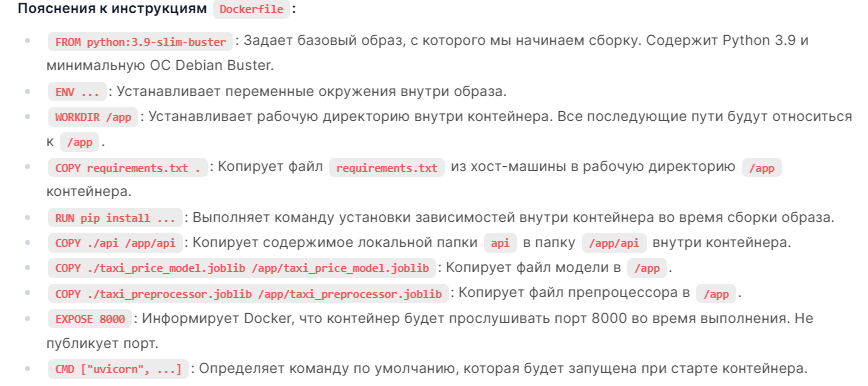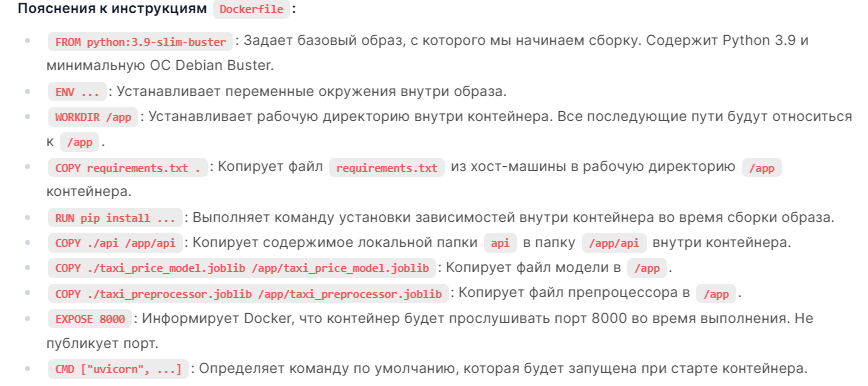

## 5.3 Проверка Путей к Модели в api/main.py


 Убедитесь, что пути к файлам .joblib в вашем скрипте api/main.py соответствуют тому, куда вы скопировали эти файлы в Dockerfile.

В нашем Dockerfile мы скопировали taxi_price_model.joblib и taxi_preprocessor.joblib в рабочую директорию /app.

В файле api/main.py код загрузки артефактов выглядит так:

In [ ]:
# Фрагмент из api/main.py
# Пути указываем относительно корня проекта, откуда будет запускаться uvicorn
model_path = 'taxi_price_model.joblib'
preprocessor_path = 'taxi_preprocessor.joblib'
# ... остальной код загрузки ...

Поскольку рабочая директория в контейнере /app, и uvicorn будет запускаться из нее, а файлы модели лежат прямо в /app, то текущие пути ('taxi_price_model.joblib', 'taxi_preprocessor.joblib') корректны. Они будут искаться относительно рабочей директории /app.

Если бы вы скопировали файлы в другое место (например, в /app/artifacts), вам нужно было бы изменить model_path = 'artifacts/taxi_price_model.joblib' и т.д. в api/main.py.

## 5.4 Создание файла .dockerignore (Рекомендация)

Чтобы ускорить сборку и уменьшить размер образа, полезно создать файл .dockerignore. Он работает аналогично .gitignore, указывая Docker, какие файлы и папки из контекста сборки (корневой папки проекта) не нужно копировать внутрь образа.



In [ ]:
touch .dockerignore

## 5.5 Сборка Docker-образа


Теперь, когда у нас есть Dockerfile и api/main.py с правильными путями, мы можем собрать Docker-образ. Сборка происходит в корне проекта, где лежит Dockerfile.

In [5]:
# docker build [опции] -t имя_образа:тег путь_к_контексту_сборки
# -t taxi-predictor-api:latest : задает имя (taxi-predictor-api) и тег (latest) для образа
# . : указывает, что контекст сборки (файлы, которые Docker может использовать) - это текущая директория

docker build -t taxi-predictor-api:latest . 

SyntaxError: invalid syntax (964288203.py, line 5)

Процесс сборки может занять некоторое время, особенно в первый раз, так как Docker будет скачивать базовый образ и устанавливать зависимости. Вы увидите логи выполнения каждой инструкции из Dockerfile. Если все пройдет успешно, в конце вы увидите сообщение типа Successfully tagged taxi-predictor-api:latest.

Вы можете увидеть созданный образ в списке локальных образов:

``docker images | grep taxi-predictor-api``

## 5.6 Запуск Контейнера Локально


Теперь запустим контейнер из только что собранного образа.



In [ ]:
# Убедитесь, что Uvicorn, запущенный ранее НЕ в Docker, остановлен (Ctrl+C)
# Иначе порт 8000 будет занят

# docker run [опции] имя_образа:тег
# -d: запустить контейнер в фоновом (detached) режиме
# -p 8000:8000 : пробросить порт 8000 хост-машины (WSL2) на порт 8000 внутри контейнера. 
#               Формат: <порт_хоста>:<порт_контейнера>
# --name taxi_api_container : присвоить контейнеру имя для удобства управления
# taxi-predictor-api:latest : имя и тег образа, из которого создаем контейнер

docker run -d -p 8000:8000 --name taxi_api_container taxi-predictor-api:latest 

In [ ]:
docker ps 


## 5.7 Тестирование API из Docker-контейнера


Теперь API работает внутри изолированного контейнера, но благодаря пробросу порта (-p 8000:8000) оно доступно на localhost:8000 вашей хост-машины (или WSL2).

Протестируйте его точно так же, как вы тестировали API, запущенное через uvicorn напрямую:

Браузер:
- Откройте http://localhost:8000 (должно быть приветствие).
- Откройте http://localhost:8000/docs (должна быть Swagger UI документация).
- Откройте http://localhost:8000/health (должен быть статус OK).


In [ ]:
curl -X POST "http://localhost:8000/predict/" \
-H "Content-Type: application/json" \
-d '{
  "distance_km": 7.2,
  "time_of_day": "Утро",
  "weekend": 0,
  "passengers": 1
}'
# Ожидаем JSON с predicted_price

Streamlit Dashboard:
Запустите Streamlit дашборд (если он еще не запущен): streamlit run dashboard.py
Дашборд по-прежнему обращается к http://localhost:8000/predict/. Теперь этот адрес ведет к API внутри Docker-контейнера. Проверьте, что расчет стоимости в дашборде работает.

## 5.8 Управление Контейнером


###### Просмотр логов:
    Полезно для отладки, если что-то идет не так внутри контейнера.


In [ ]:
docker logs taxi_api_container 
# Чтобы следить за логами в реальном времени (как tail -f):
# docker logs -f taxi_api_container 

###### Остановка контейнера:


In [ ]:
docker stop taxi_api_container

###### Запуск остановленного контейнера:


In [ ]:
Запуск остановленного контейнера:


###### Перезапуск контейнера:


In [ ]:
docker restart taxi_api_container

###### Удаление контейнера (нужно сначала остановить):


In [ ]:
docker stop taxi_api_container 
docker rm taxi_api_container
# Удалить все остановленные контейнеры: docker container prune -f

###### Удаление образа:


In [ ]:
# Сначала нужно остановить и удалить все контейнеры, созданные из этого образа
docker rmi taxi-predictor-api:latest
# Удалить все неиспользуемые (dangling) образы: docker image prune -f

# 6. Развертывание Docker-контейнера на Удаленном Сервере

*   **Задача:** Запустить наш Docker-контейнер с API на удаленном сервере, чтобы сделать его доступным извне (например, для других сервисов или для демонстрации).
*   **Подход:** Мы будем использовать Docker Hub (или другой container registry) как промежуточное хранилище для нашего Docker-образа. Мы загрузим ("push") наш локально собранный образ в Docker Hub, а затем скачаем ("pull") его на удаленном сервере и запустим.
*   **Пререквизиты:**
    1.  **Удаленный сервер:** Доступ по SSH к Linux-серверу (например, VPS от DigitalOcean, Vultr, Linode, AWS EC2, Google Cloud VM, или ваш собственный сервер).
    2.  **Docker на сервере:** На удаленном сервере должен быть установлен Docker Engine. Инструкции по установке обычно есть в документации вашего хостинг-провайдера или на официальном сайте Docker ([https://docs.docker.com/engine/install/](https://docs.docker.com/engine/install/)). Проверить установку можно командой `docker --version` на сервере.
    3.  **Docker Hub Аккаунт:** Зарегистрированный аккаунт на [https://hub.docker.com/](https://hub.docker.com/). Это бесплатно для публичных репозиториев. Запомните ваш Docker Hub ID (имя пользователя).
    4.  **(Опционально) Firewall:** Убедитесь, что firewall на вашем сервере разрешает входящие соединения на порт, который вы собираетесь использовать (в нашем случае, порт 8000/tcp). Настройка зависит от ОС и конфигурации сервера (например, `ufw allow 8000/tcp` для UFW в Ubuntu).

## 6.1 Загрузка Образа в Docker Hub (Локально)

Сначала нам нужно "отправить" наш локально собранный образ `taxi-predictor-api:latest` в ваш репозиторий на Docker Hub.

1.  **Войдите в Docker Hub из терминала:**


In [ ]:
docker login
    # Вам будет предложено ввести ваш Docker Hub ID и пароль (или токен доступа)
    ```
    При успешном входе вы увидите сообщение "Login Succeeded".

2.  **Переименуйте (тегируйте) образ:** 

Образы в Docker Hub должны иметь префикс вашего Docker Hub ID. Используем команду `docker tag`.
    ```bash
    Замените 'ваш_dockerhub_id' на ваш реальный ID в Docker Hub
    docker tag taxi-predictor-api:latest ваш_dockerhub_id/taxi-predictor-api:latest

In [ ]:
 Проверьте, что появился новый тег

 docker images | grep taxi-predictor-api
    # Вы должны увидеть две строки: 
    # ваш_dockerhub_id/taxi-predictor-api   latest    <image_id>   ...
    # taxi-predictor-api                   latest    <image_id>   ... 
    ```

3.  **Загрузите образ в Docker Hub:**


In [ ]:
# Замените 'ваш_dockerhub_id' на ваш реальный ID в Docker Hub
    docker push ваш_dockerhub_id/taxi-predictor-api:latest

In [ ]:
 Начнется процесс загрузки слоев образа в Docker Hub. Это может занять некоторое время в зависимости от размера образа и скорости вашего интернета. После завершения вы можете зайти на сайт Docker Hub и увидеть новый репозиторий `taxi-predictor-api` в вашем профиле.

    *Альтернатива:* Если вы не хотите использовать Docker Hub (например, для приватных проектов без платного аккаунта), можно сохранить образ в архив (`docker save -o image.tar ваш_dockerhub_id/taxi-predictor-api:latest`), скопировать архив на сервер (например, через `scp image.tar пользователь@адрес_сервера:~/`) и загрузить его на сервере (`docker load -i image.tar`). Но использование registry (как Docker Hub) обычно удобнее.


## 6.2 Подключение к Серверу и Загрузка Образа (На Сервере)


1.  **Подключитесь к серверу по SSH:**


In [ ]:
    ssh пользователь@адрес_сервера 


2.  **Скачайте образ из Docker Hub:**


In [ ]:
Замените 'ваш_dockerhub_id' на ваш реальный ID в Docker Hub
    docker pull ваш_dockerhub_id/taxi-predictor-api:latest
    ```
    Docker на сервере скачает образ из вашего репозитория Docker Hub.

3.  **Проверьте, что образ скачался:**


In [ ]:
    docker images | grep taxi-predictor-api


## 6.3 Запуск Контейнера на Сервере


In [ ]:
 Выполните команду на удаленном сервере

# Проверьте, не занят ли порт 8000 на сервере (например, командой `ss -tulnp | grep 8000`)
# Если порт занят, либо остановите сервис, который его использует, 
# либо выберите другой порт хоста для маппинга (например, -p 8080:8000)

# Запускаем контейнер в фоновом режиме (-d)
# Пробрасываем порт 8000 сервера на порт 8000 контейнера (-p 8000:8000)
# Даем имя контейнеру (--name running_taxi_api)
# Указываем имя образа для запуска
docker run -d -p 8000:8000 --name running_taxi_api ваш_dockerhub_id/taxi-predictor-api:latest

In [ ]:
# Выполните команду на удаленном сервере
docker ps | grep running_taxi_api

## 6.5 Завершение Работы на Сервере
Просмотр логов: docker logs running_taxi_api
Остановка контейнера: docker stop running_taxi_api
Удаление контейнера: docker rm running_taxi_api
Выход из SSH сессии: exit

# 7. Заключение и Следующие Шаги

*   **Подведение итогов:** Мы успешно прошли все ключевые этапы:
    *   Сгенерировали данные и создали базу SQLite.
    *   Провели анализ и обучили модель в Jupyter Notebook.
    *   Сохранили артефакты модели (модель и препроцессор).
    *   Создали API с FastAPI для доступа к модели.
    *   Разработали интерактивный дашборд на Streamlit для взаимодействия с API.
    *   Упаковали API в Docker-контейнер.
    *   Развернули контейнер с API на удаленном сервере.
    *   Использовали Git для контроля версий на каждом этапе.
*   **Ключевые выводы:**
    *   Понимание полного жизненного цикла DS-проекта, даже в упрощенном виде.
    *   Важность разделения этапов (анализ, API, интерфейс).
    *   Польза инструментов вроде FastAPI, Streamlit, Docker для быстрой разработки и развертывания.
    *   Необходимость правильной обработки артефактов (модели, препроцессоры).
    *   Основы контейнеризации и ее преимущества.
*   **Возможные улучшения и следующие шаги:**
    *   **Улучшение Модели:** Использовать более сложные модели, провести более тщательный Feature Engineering и подбор гиперпараметров.
    *   **Тестирование:** Написать Unit-тесты для кода API (например, с помощью `pytest` и `httpx`), возможно, интеграционные тесты.
    *   **CI/CD:** Настроить конвейер непрерывной интеграции и доставки (например, с помощью GitHub Actions или GitLab CI) для автоматической сборки, тестирования и развертывания Docker-образа при изменениях в коде.
    *   **Docker Compose:** Использовать Docker Compose для одновременного запуска и управления несколькими связанными контейнерами (например, API, база данных (если бы она была не SQLite), дашборд Streamlit).
    *   **HTTPS:** Настроить безопасное соединение HTTPS для API на сервере (часто делается с помощью обратного прокси, например, Nginx или Traefik, который также может обрабатывать SSL-сертификаты, например, от Let's Encrypt).
    *   **Мониторинг и Логирование:** Настроить сбор метрик (например, с Prometheus и Grafana) и централизованное логирование (например, ELK stack или Loki) для API в продакшене.
    *   **Управление Артефактами:** Использовать инструменты вроде MLflow или DVC для отслеживания экспериментов, версионирования моделей и данных. Хранить большие артефакты в облачных хранилищах (S3, GCS, Azure Blob Storage).
    *   **Развертывание Дашборда:** Упаковать Streamlit дашборд в свой Docker-контейнер и развернуть его рядом с API на сервере.
    *   **Оркестрация:** Для более сложных приложений рассмотреть использование оркестраторов контейнеров, таких как Kubernetes.